# Water Observations from Space (WOFS) using Seninel-1 Data 

### Background

Understanding Australia's flood history is an important part of making better predictions about how we will be affected by flooding in the future.

To this end, Geoscience Australia developved the Australian Water Observations from Space (WOFS) algorithm. WOFS provides an estimate of how often water was seen at a particular location. This water detection algorithm is significantly better than the Landsat QA water flag or the NDWI index for water identification. 

For more information, visit this website: http://www.ga.gov.au/scientific-topics/hazards/flood/wofs

 - Sentinel 2 : The lowest time period for reliably clear data on average is around a month, although significant cloud can change this figure. Runtime is very long however.
 - Landsat 8 : The lowest time period for reliably clear data on average is around 4 months, although significant cloud can change this figure.

Adaptation and fixing of this product to run in the Jupyter Lab environment of Satellite Applications Catapult was primarily done by Michael Young of the Geospatial Inteligence team, with the help of Luigi Di Fraia, Tom Jones and fellow intern Jonathan Hicks. 

## Preliminary steps

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'my_app')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Import other required packages
import matplotlib.pyplot as plt
import numpy as np  
import xarray as xr  

#-----------------------------

%matplotlib inline
import datacube
import xarray as xr
from datetime import datetime
import warnings; warnings.simplefilter('ignore')
import imp
from time import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
#dc = datacube.Datacube(app = 'ALOS Demo', config = '/home/localuser/.datacube.conf')



In [3]:
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')
client

<Client: scheduler='tcp://10.244.3.78:8786' processes=3 cores=24>

## Define product and extent

### Available extents

We've listed the available ingested data that you can explore in the ODC Sandbox. The latitude, longitude and time ranges correspond to the boundaries of the ingested data cubes. You'll be able to explore sub-samples of these cubes. You'll also need to provide the platform, product and resolution information for the cube you're subsampling.

In [4]:
# CHANGE HERE >>>>>>>>>>>>>>>>>

# Select a product and platform

# platform= 'SENTINEL_2'
# product='s2_esa_sr_granule'
platform='LANDSAT_8'
product='ls8_usgs_sr_scene'
# resolution = (-0.000269494585236, 0.000269494585236)
resolution = (-0.0001, 0.0001)

output_crs = 'EPSG:4326'

### Set extent information

You can change the values in this cell to specify the extent of the data cube you wish to analyse.

You should select a sub-sample from one of the four data cubes listed above. When subsampling, keep in mind that:
* Your latitude and longitude bounds should be within the extents given.
* Your area should be small to keep load times reasonable (less than 0.5 square degrees).
* Your time period should be within the extents given.

You should format the variables as:
* `latitude = (min_latitude, max_latitude)`
* `longitude = (min_longitude, max_longitude)`
* `time_extents = (min_time, max_time)`, where each time has the format: `'YYYY-MM-DD'`.

In [5]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>

# Select a sub-region to analyse
# latitude = (-18.0563, -17.8745)
# longitude = (178.2029, 178.4418,)
# latitude = (-17.9, -17.7)
# longitude = (177.5, 177.7)
# South East Coast
latitude = (-18.1938, -17.9991)
longitude = (178.3815, 178.7522)
ar=(longitude[1]-longitude[0])/(latitude[1]-latitude[0])

# time_extents = ('2018-08-25', '2018-09-15')
time_extents = ('2019-01-01', '2019-04-01')

In [6]:
import pandas as pd

### View the region before loading

The next cell will allow you to view the area you'll be analysing by displaying a red bounding box on an interactive map. You can change the extents in the previous cell and rerun the `display_map()` command to see the resulting bounding box.

In [7]:
# The code below renders a map that can be used to view the analysis region.
from utils.data_cube_utilities.dc_display_map import display_map

display_map(latitude, longitude)

## Load the dataset and the required spectral bands or other parameters
The data is loaded by passing the product and area information to the `dc.load()` function. As a part of this load, we also specify the measurements we want in the form of the Landsat bands.

The load can take up to a few minutes, so please be patient.

In [8]:
%env AWS_NO_SIGN_REQUEST=YES
if product == 's1g_gamma0_scene':
    dataset = dc.load(
    latitude=latitude,
    longitude=longitude,
    platform=platform,
    time=time_extents,
    product=product,
    output_crs=output_crs,
    resolution=resolution,
    measurements=(
        'vv',
        'vh'
    )
) 
elif product == 's2_esa_sr_granule':
    dataset = dc.load(
    latitude=latitude,
    longitude=longitude,
    platform=platform,
    time=time_extents,
    product=product,
    output_crs=output_crs,
    resolution=resolution,
    measurements=(
        'red',
        'green',
        'blue',
        'nir',
        'swir_1',
        'swir_2',
        'scene_classification'
        )
    ) 
    dataset['swir1']=dataset.swir_1
    dataset['swir2']=dataset.swir_2    
   
elif product=='ls8_usgs_sr_scene':
    dataset = dc.load(
    latitude=latitude,
    longitude=longitude,
    platform=platform,
    time=time_extents,
    product=product,
    output_crs=output_crs,
    resolution=resolution,
    measurements=(
        'red',
        'green',
        'blue',
        'nir',
        'swir1',
        'swir2',
        'pixel_qa'
    )
) 
   

env: AWS_NO_SIGN_REQUEST=YES


In [9]:
# import time
# t=time.time()
# if product == 's2_esa_sr_granule':
#     scene_classification=dataset.scene_classification
#     pixel_qa=scene_classification-scene_classification
#     import dask.array as da
#     chunk_shape=(1,100,100)
#     scene_classification=da.from_array(scene_classification, chunks=chunk_shape)
#     inputs=list(range(12))
# #     from utils.senpixel_qa import senpixel_qa
# #     outputs=list(map(senpixel_qa, inputs))
#     outputs=[1, 1, 1, 328, 322, 322, 324, 1, 386, 480, 328, 336]
#     mydict=dict(zip(inputs, outputs))
#     pixel_qa=scene_classification.map_blocks(lambda x: np.vectorize(mydict.get)(x), dtype=scene_classification.dtype).compute() 
# #     dataset['pixel_qa']=pixel_qa[dims=dataset.time, dataset.latitude, dataset.longitude]

# #     dataset['pixel_qa']=pixel_qa[[dataset.time, dataset.latitude, dataset.longitude], pixel_qa]
#     pixel_qa=xr.DataArray(pixel_qa, coords=[dataset.time, dataset.latitude, dataset.longitude])
#     dataset['pixel_qa']=pixel_qa
# print(time.time()-t)

It is often useful to print the loaded data to check the dimensions and data variables

When looking at the dimensions, the numbers for latitude and longitude correspond to the number of pixels in each dimension and the number for time corresponds to the number of time steps. 

In [10]:
# Displays an overview of the loaded data
print(dataset)

<xarray.Dataset>
Dimensions:    (latitude: 1948, longitude: 3708, time: 13)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-13T22:06:28.134194 ... 2019-03-18T22:06:36.782391
  * latitude   (latitude) float64 -18.0 -18.0 -18.0 ... -18.19 -18.19 -18.19
  * longitude  (longitude) float64 178.4 178.4 178.4 178.4 ... 178.8 178.8 178.8
Data variables:
    red        (time, latitude, longitude) int16 491 491 177 177 ... 22 22 22 14
    green      (time, latitude, longitude) int16 852 852 571 571 ... 76 76 76 63
    blue       (time, latitude, longitude) int16 316 316 -32 -32 ... 181 181 167
    nir        (time, latitude, longitude) int16 5128 5128 4849 ... 32 32 27
    swir1      (time, latitude, longitude) int16 2174 2174 1934 ... 76 76 74
    swir2      (time, latitude, longitude) int16 1085 1085 847 847 ... 69 69 67
    pixel_qa   (time, latitude, longitude) uint16 322 322 322 ... 324 324 324
Attributes:
    crs:      EPSG:4326


## Masking out clouds

As part of the utilities for the Open Data Cube, we have defined a function to mask clouds based on the quality assurance information for Landsat. The function returns an `xarray.DataArray` object containing the mask. This can then be passed to the `where()` function, which masks the data.

In [11]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask

cloud_mask = landsat_qa_clean_mask(dataset, platform)

cleaned_dataset = dataset.where(cloud_mask)

## Remove fill tiles 
Removes the abundance of blank fill tiles which are often imported from the cube when loading LS8 data. 

In [12]:
fcleaned_dataset=cleaned_dataset.fillna(0)
clean_list=np.array([])
for i in range(len(fcleaned_dataset.time)):
    if int(np.sum(fcleaned_dataset.red.isel(time=i).values))==0:
        clean_list=np.append(clean_list, 0)
    else:
        clean_list=np.append(clean_list, 1)


clean_index=list(np.where(clean_list==1)[0])
cleaned_dataset=cleaned_dataset.isel(time=clean_index)

## View the masked data 

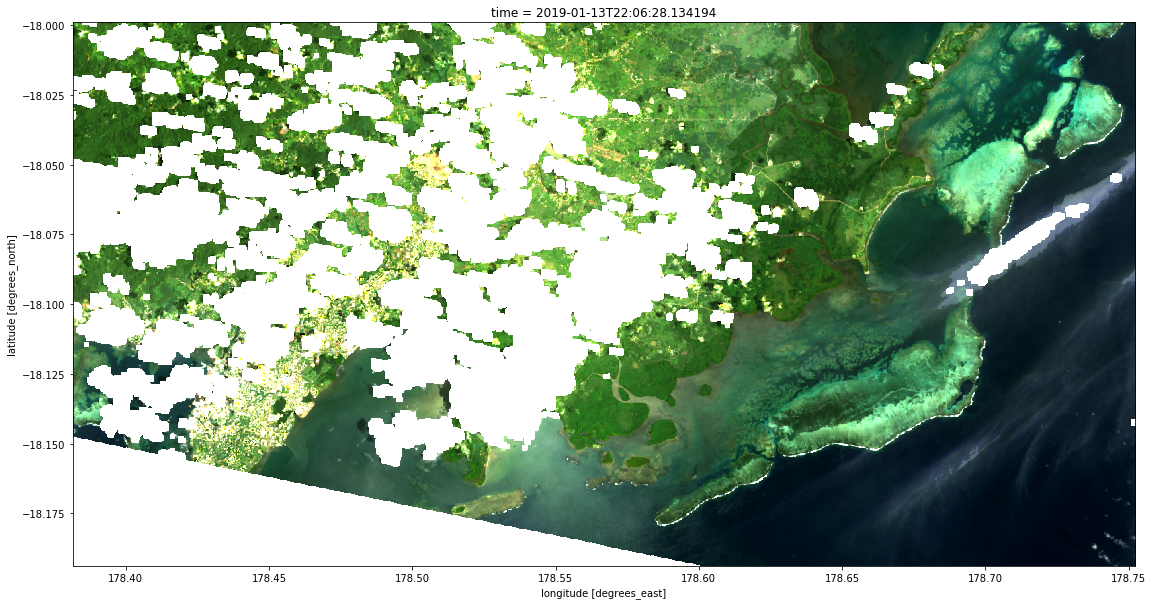

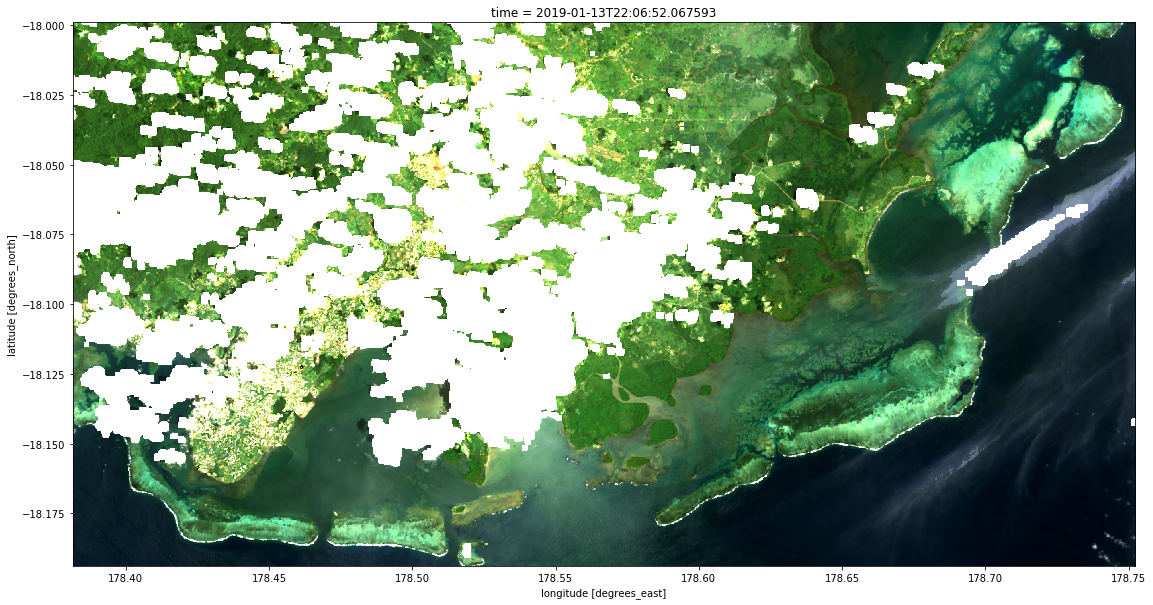

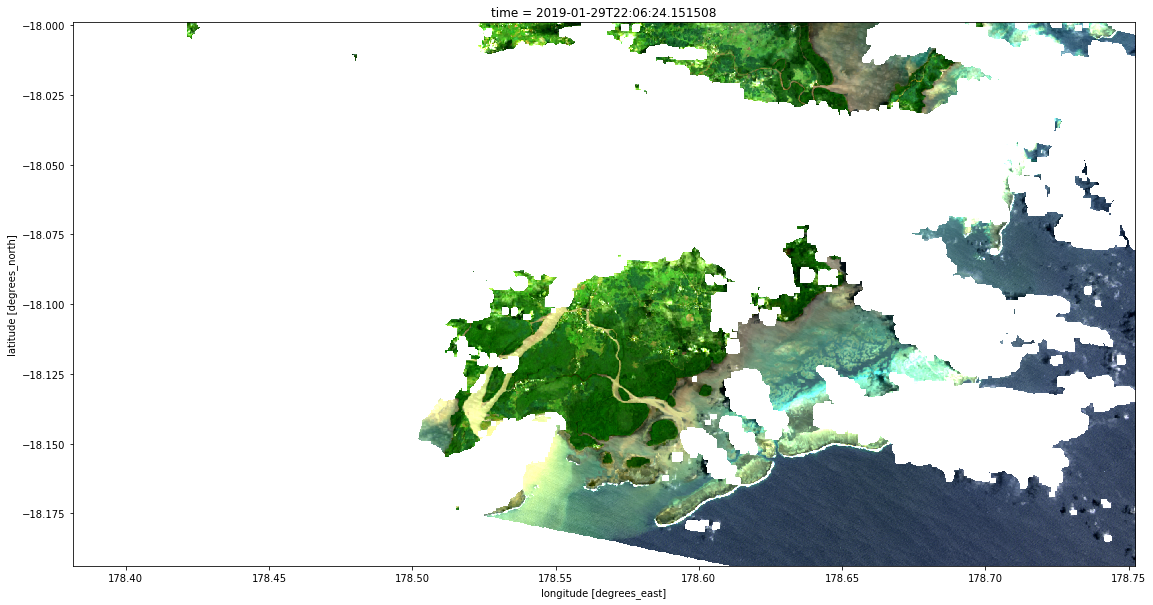

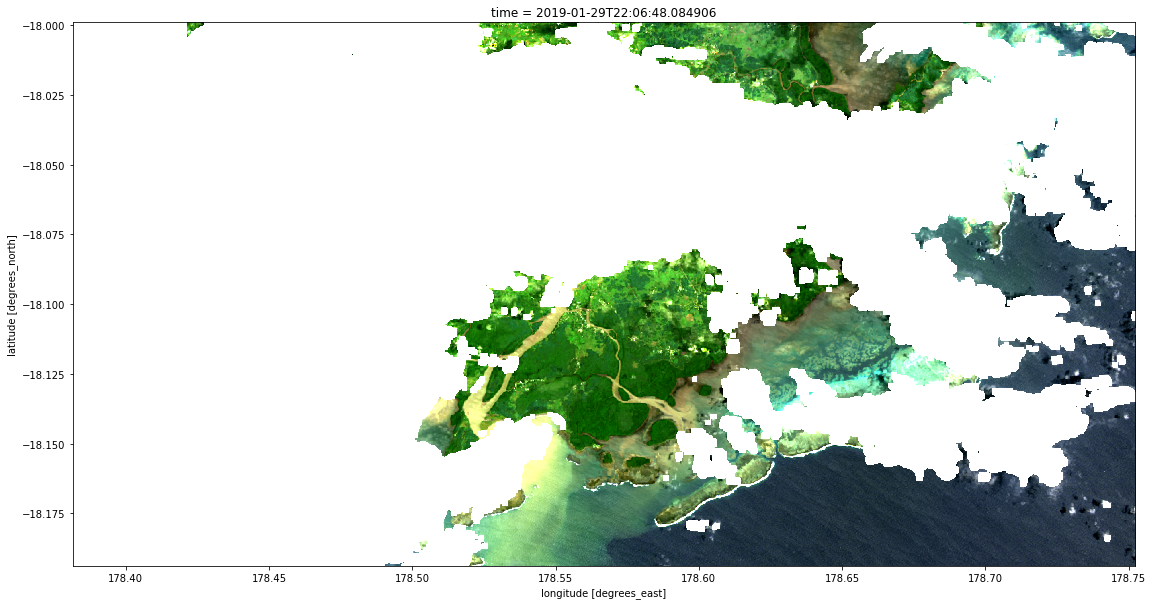

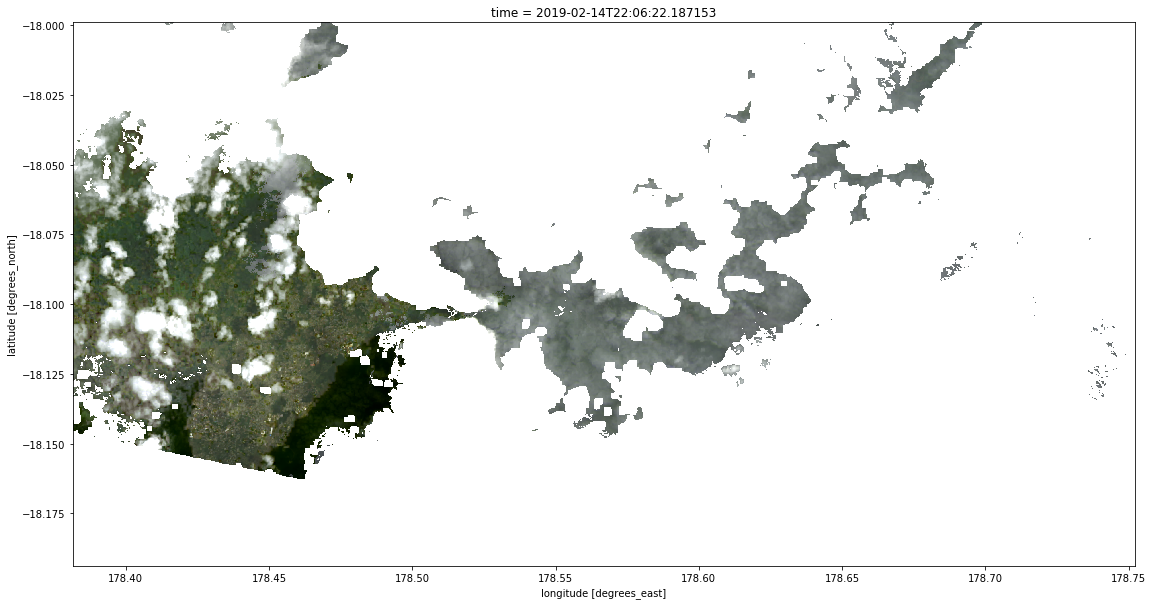

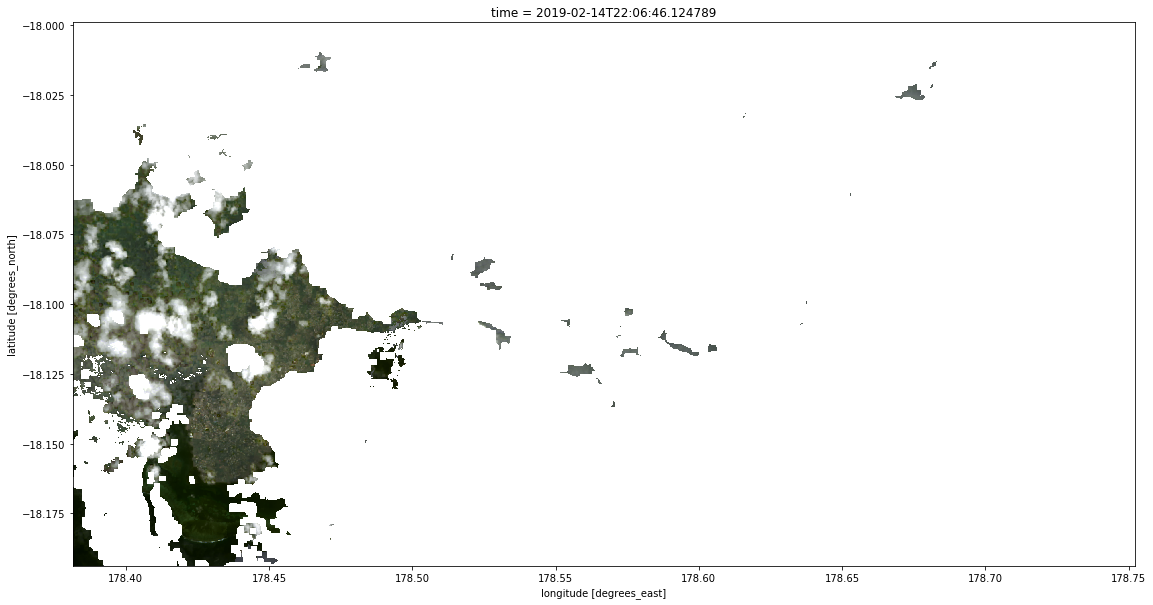

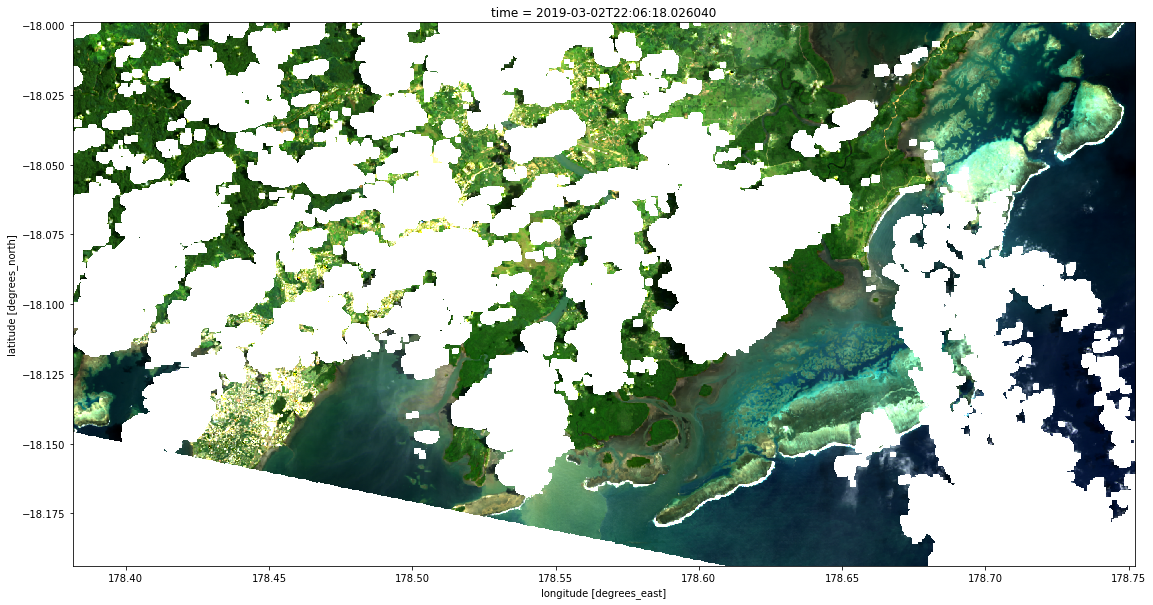

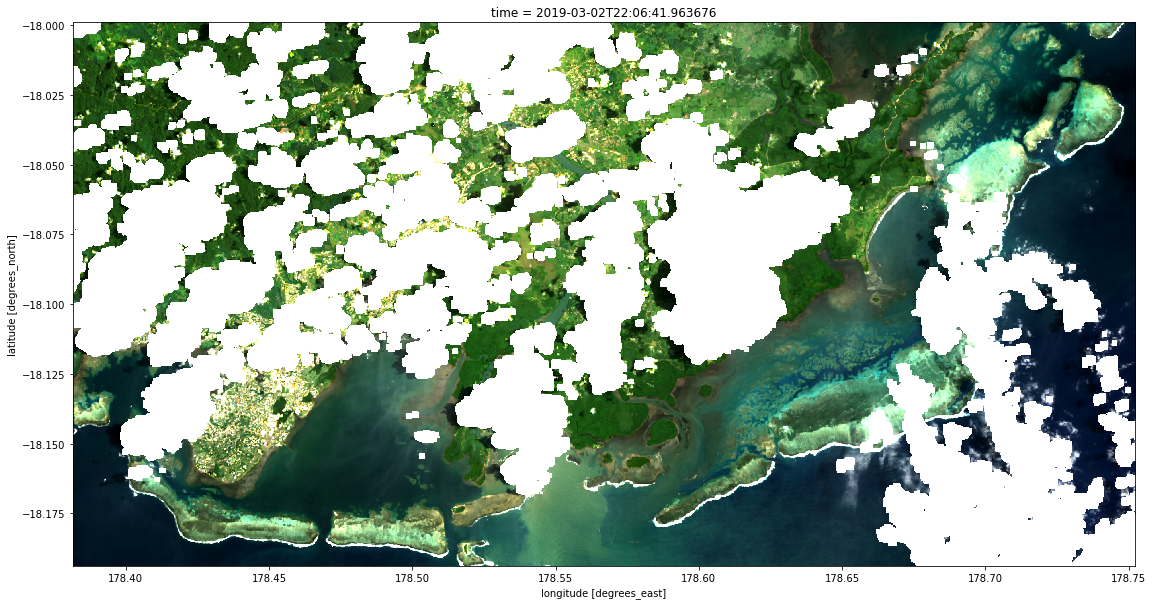

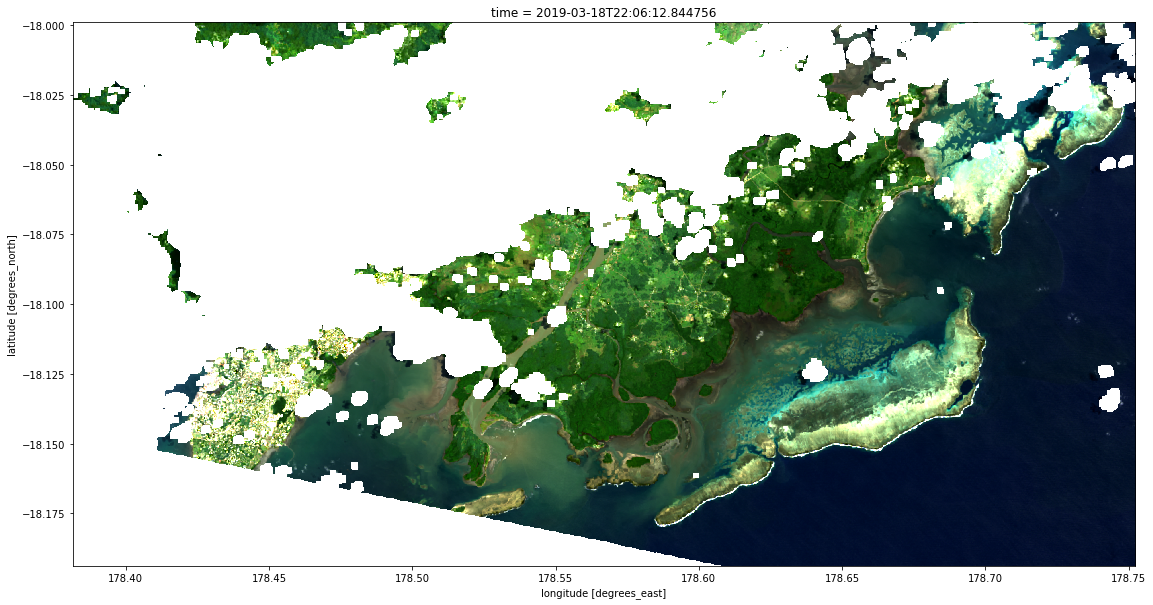

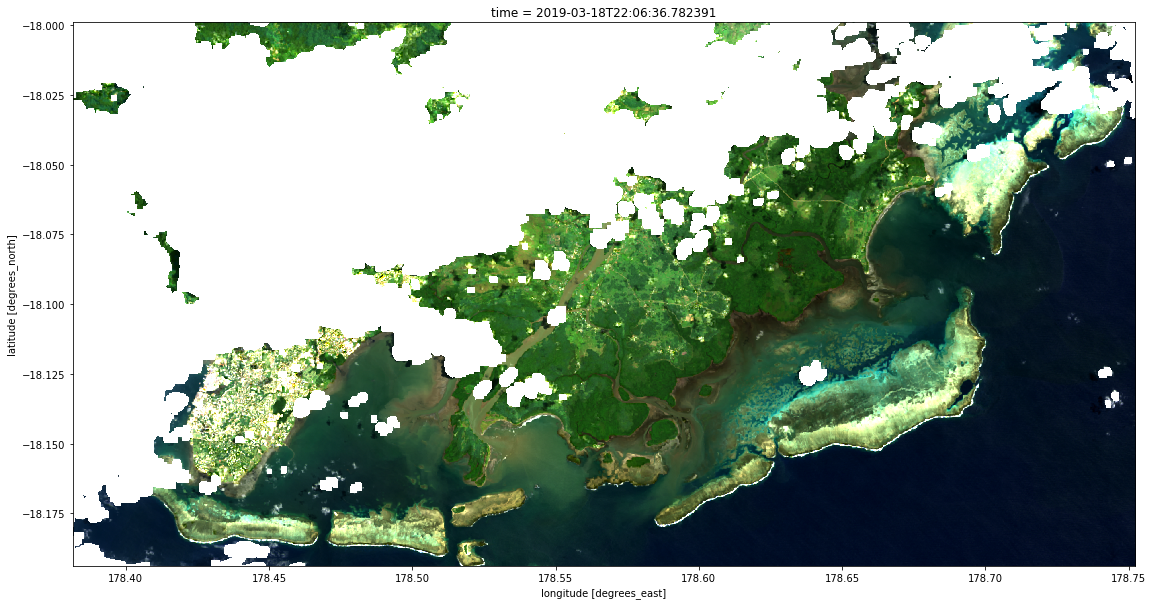

In [13]:
# run w/ clean dataset rather than the mask
rgb = ['red','green','blue']
for i, t in enumerate(cleaned_dataset.time):
    cleaned_dataset[rgb].isel(time=i).to_array().plot.imshow(robust=True, figsize=(10*ar,10))


## Time Series Water Detection Analysis
Time series output of the Australian Water Detection from Space (WOFS) results. The results show the percent of time that a pixel is classified as water over the entire time series. BLUE = frequent water, RED = infrequent water.

The first step is to classify the dataset, which can be done with the `wofs_classify()` utility function.

In [14]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
ts_water_classification = wofs_classify(cleaned_dataset)


The next step is to convert "no data" pixels to `nan`. A "no data" pixel has a value of `-9999` in Landsat data.

In [15]:
if product=='ls8_usgs_sr_scene':
    ts_water_classification = ts_water_classification.where(ts_water_classification != -9999).astype(np.float16)
elif product =='s2_esa_sr_granule':
    ts_water_classification = ts_water_classification.where(ts_water_classification != 0).astype(np.float16)


Finally, the percentage of time that a pixel is classified as water is calculated by taking the average classification value over time and multiplying it by 100. The mean calculation ignores `nan` values.

In [16]:
water_classification_percentages = (ts_water_classification.mean(dim=['time']) * 100).wofs.rename('water_classification_percentages')

## Exploring the results

After calculating the water classification percentage, we can plot it both as a 2-dimensional image and 1-dimensional summary.

The first step is to choose a colour map and change the colour of `nan` pixels to black. We choose to use the `RdBu` colour map to highlight water in blue and land in red.

In [17]:
# import color-scheme and set nans to black
from matplotlib.cm import RdBu
RdBu.set_bad('black', 1)

In the following figure, dark blue indicates pixels that experienced significant or constant water over the time series, where dark red indicates pixels that have experienced little or no water over the time series.

You can adjust the figure size to avoid distortion. Use the `latitude` and `longitude` dimensions from the `xarray` description to get an idea for the desired aspect ratio. You'll need to add some space in the x-dimension to account for the presence of the colour bar. 

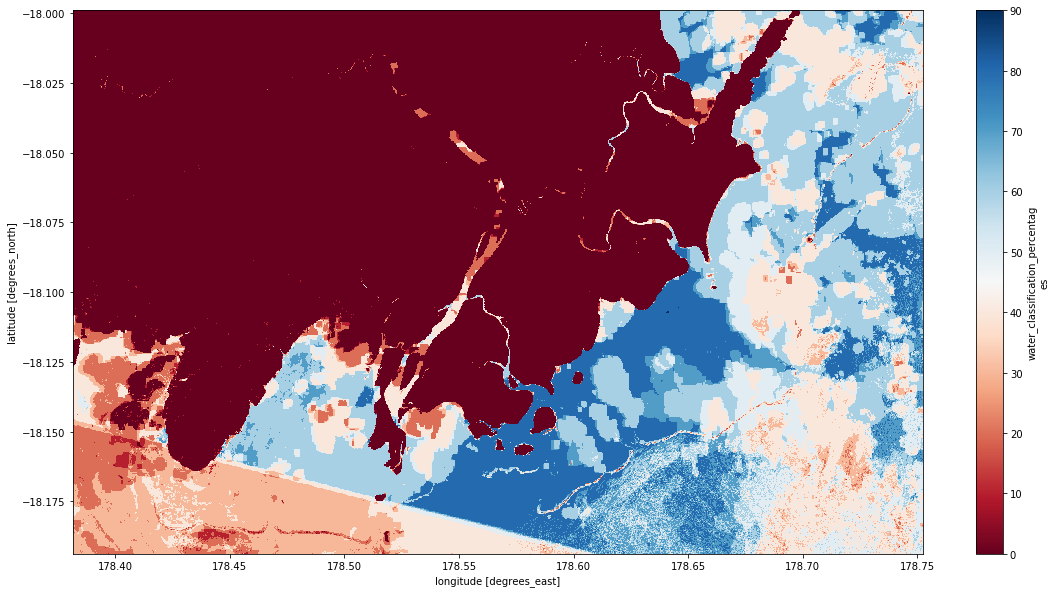

In [18]:
# CHANGE HERE >>>>>>>>>>>>>>>>>

water_classification_percentages.plot(cmap=RdBu, figsize=(10*ar, 10))
plt.show()

By taking the average classification value over the latitude and longitude, we can assess whether the fraction of water pixels has changed significantly over time. It should be noted that clouds can impact the statistical results. The water classification percentage can be displayed on either a linear scale or a logarithmic scale.

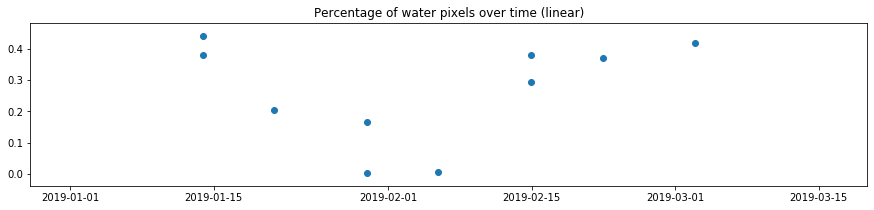

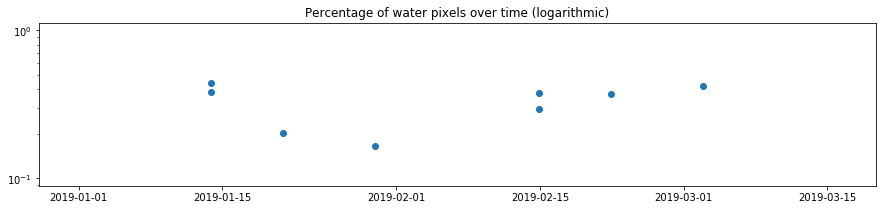

In [19]:
water_classification_mean_percentages = (ts_water_classification.mean(dim=['latitude', 'longitude']) * 100).wofs.rename('water_classification_percentages')


wofs=ts_water_classification.wofs.values
averages=np.mean(wofs, axis=(1,2))
time=list(dataset.time.values)



averages=averages[np.where(averages!=0)] #remove bogus LS8 entries
time=np.asarray(dataset.time.values)
time=time[np.where(averages!=0)]
logaverages=np.log(averages)


#Linear-scale plot
# water_classification_mean_percentages.plot(figsize=(15,3), marker='o', linestyle='None')
plt.figure(figsize=(15,3))
plt.scatter(time, averages)
plt.title("Percentage of water pixels over time (linear)")
plt.show()

#Logarithmic-scale plot
# water_classification_mean_percentages.plot(figsize=(15,3), marker='o', linestyle='None')
plt.figure(figsize=(15,3))
plt.title("Percentage of water pixels over time (logarithmic)")
plt.scatter(time, averages)
plt.gca().set_yscale('log')

## Export to GeoTIFF
To perform further analysis, use the following cells to download the data in GeoTIFF format. This makes use of the data cube utility function `export_slice_to_geotiff()`. 

Before exporting, we'll construct an `xarray` dataset to store the water classification percentage data we created earlier.

In [20]:
# Save the water percentage data to a GeoTIFF
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

# construct the xarray Dataset
dataset_to_export = xr.Dataset(coords=water_classification_percentages.coords, attrs=ts_water_classification.attrs)

# add the water classification percentages to the new xarray Dataset
dataset_to_export['wofs_pct'] = (water_classification_percentages/100).astype(np.float32)

The export command on the following line is commented out to avoid overwriting files. If you would like to export data, please change the filename before uncommenting the next line.

In [21]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>>>>>>

# export_slice_to_geotiff(dataset_to_export, 'geotiffs/WOFS_Percentage_demo.tif')

By default, the files have been saved in the `geotiffs` folder, which sits inside the `dcal` folder that this notebook is stored in. Use the following cell to list the contents of the `geotiffs` folder.

*NOTE:* Starting a command with `!` allows you to run that command in the Jupyter environment's command line.

In [22]:
!ls -lah geotiffs/

total 12K
drwxrwsr-x 2 jovyan users 4.0K Aug  2 13:08 .
drwxrwsr-x 6 jovyan users 4.0K Aug 29 11:03 ..
-rw-rw-r-- 1 jovyan users   38 Aug  2 13:08 README.md
